CSCI E-82 2018 
Homework 6 
Due: December 5, 2018

Team members:
Michelle Amaral
Esthove Varghese Anish Raj Stephen Jeyaraj
Paul Washburn

The goal of this assignment is to determine whether the 36 plays attributed to William Shakespeare were indeed authored by one person, and if so, are we able to classify Shakespeare’s lines from those of his contemporaries. Authorship questions have arisen due to the inconceivability that only one person could write 36 of the greatest works of all time within a 24 year span. Alternative possibilities to consider, then, include: one or more ghost writers who wrote for Shakespeare; a collaborative group that included Shakespeare; a collaborative group that did not include Shakespeare. In addition, it is possible that Shakespeare solely authored some of the 36 plays but other people wrote the remainder, either by themselves or in collaboration with others.

Although we don’t have a “gold” ground truth sample of Shakespeare’s writing, we can perform experiments to determine whether one person authored the 36 plays. Our null hypothesis is that one person wrote all 36 plays that are in question. The following experiments we conducted are an attempt to disprove this hypothesis.

We began with an exploratory analysis of the data. When considering the number of lines in each play, “Hamlet” was the longest with 4,244 lines and “A Comedy of Errors” was the shortest with 2,055 lines. “Richard III” had the most characters with 71 while “Two Gentlemen of Verona” had the fewest with 18.

Classification techniques were used to test if Shakespeare’s lines were sufficiently different from his contemporaries’ writings such that a model could be built that accepts any given line, then correctly classifies it as Shakespeare or not.  The plays of 6 of his contemporaries were gathered, processed and labeled as “not shakespeare”, then combined with Shakespeare’s.  Several classification algorithms were tested in combination with a TF-IDF and CountVectorizer pre-processing techniques.  Grid searches were performed to find best models.  While Shakespeare wrote about 33% of the lines in the dataset, the best model was able to classify 92% of that 33% correctly (recall).  Overall, the best model was very simple (using a CountVectorizer and MultinomialNB) and had an accuracy score of 85.98%.  It is likely that different techniques, such as word embeddings, could yield improvements.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
from time import time
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim import corpora, models, matutils, similarities
from gensim.models.ldamulticore import LdaMulticore
from tld import get_tld
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import requests
from bs4 import BeautifulSoup
import gensim
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import os
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from joblib import load, dump
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.base import BaseEstimator
from sklearn.naive_bayes import MultinomialNB

warnings.filterwarnings('ignore')
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
sns.set_style('whitegrid')
%matplotlib inline

def binary_confusion_matrix(y, y_hat, as_pct=False, verbose=True):
    cm = pd.DataFrame(confusion_matrix(y, y_hat), 
                      columns=['(+) actual', '(-) actual'],
                      index=['(+) predicted', '(-) predicted'])
    if as_pct:
        cm = cm / cm.sum().sum()
        
    P = cm['(+) actual'].sum()
    N = cm['(-) actual'].sum()
    total = P + N
    TP = cm.loc['(+) predicted', '(+) actual']
    FP = cm.loc['(+) predicted', '(-) actual']
    TN = cm.loc['(-) predicted', '(-) actual']
    FN = cm.loc['(-) predicted', '(+) actual']
    TPR = TP / (TP + FN)          # recall/sensitivity
    TNR = TN / (TN + FP)   # specificity
    FPR = FP / (FP + TN)   # fall-out
    FNR = FN / (FN + TP)   # miss rate
    PPV = TP / (TP + FP)   # precision
    NPV = TN / (TN + FN)   # neg predictive value
    
    if verbose:
        print('''
        Condition Positive:                        %i
        Condition Negative:                        %i
        Total Observations:                        %i
        
        True Positive:                             %i
        True Negative:                             %i
        False Positive:                            %i
        False Negative                             %i
        
        True Positive Rate (recall):               %.2f%%
        True Negative Rate (specificity):          %.2f%%
        False Positive Rate (fall-out):            %.2f%%
        False Negative Rate (miss rate):           %.2f%%
        
        Positive Predictive Value (precision):     %.2f%%
        Negative Predictive Value:                 %.2f%%
        ''' %(P, N, total,
             TP, TN, FP, FN,
             TPR*100, TNR*100, FPR*100, FNR*100, 
             PPV*100, NPV*100))
        
    metrics = {'P': P, 'N': N, 'total': total, 
              'TP': TP, 'FP': FP, 'TN': TN, 'FN': FN,
              'TPR': TPR, 'TNR': TNR, 'FPR': FPR, 'FNR': FNR, 'PPV': PPV, 'NPV': NPV}
    
    return cm, metrics

class TextCleaner(TransformerMixin):
    """Text cleaning to slot into sklearn interface"""

    def __init__(self, remove_stopwords=True, remove_urls=True,
                 remove_puncts=True, lemmatize=True, extra_punct='',
                 custom_stopwords=[], custom_non_stopwords=[],
                 verbose=True, parser='big'):
        """
        INPUT: remove_stopwords - bool - remove is, there, he etc...
               remove_urls - bool - 't www.monkey.com t' --> 't com t'
               remove_punct - bool - all punct and digits gone
               lemmatize - bool - whether to apply lemmtization
               extra_punct - str - other characters to remove
               custom_stopwords - list - add to standard stops
               custom_non_stopwords - list - make sure are kept
               verbose - bool - whether to print progress statements
               parser - str - 'big' or small, one keeps more, and is slower
        OUTPUT: self - **due to other method, not this one
        """
        # Initialize passed Attributes to specify operations
        self.remove_stopwords = remove_stopwords
        self.remove_urls = remove_urls
        self.remove_puncts = remove_puncts
        self.lemmatize = lemmatize

        # Change how operations work
        self.custom_stopwords = custom_stopwords
        self.custom_non_stopwords = custom_non_stopwords
        self.verbose = verbose

        # Set up punctation tranlation table
        self.removals = string.punctuation + string.digits + extra_punct
        self.trans_table = str.maketrans({key: None for key in self.removals})

        #Load nlp model for parsing usage later
        self.parser = spacy.load('en_core_web_sm', 
                                 disable=['parser','ner','textcat'])
        #from spacy.lang.en import English
        if parser == 'small':
            self.parser = spacy.load('en')#English()

        #Add custom stop words to nlp
        for word in self.custom_stopwords:
            self.parser.vocab[word].is_stop = True

        #Set custom nlp words to be kept
        for word in self.custom_non_stopwords:
            self.parser.vocab[word].is_stop = False


    def transform(self, X, y=None):
        """take array of docs to clean array of docs"""
        # Potential replace urls with tld ie www.monkey.com to com
        if self.remove_urls:
            start_time = time()
            if self.verbose:
                print("CHANGING URLS to TLDS...  ", end='')
            X = [self.remove_url(doc) for doc in X]
            if self.verbose:
                print(f"{time() - start_time:.0f} seconds")

        # Potentially remove punctuation
        if self.remove_puncts:
            start_time = time()
            if self.verbose:
                print("REMOVING PUNCTUATION AND DIGITS... ", end='')
            X = [str(doc).lower().translate(self.trans_table) for doc in X]
            if self.verbose:
                print(f"{time() - start_time:.0f} seconds")

        # Using Spacy to parse text
        start_time = time()
        if self.verbose:
            print("PARSING TEXT WITH SPACY... ", end='')
            
        X = list(self.parser.pipe(X))
        if self.verbose:
            print(f"{time() - start_time:.0f} seconds")

        # Potential stopword removal
        if self.remove_stopwords:
            start_time = time()
            if self.verbose:
                print("REMOVING STOP WORDS FROM DOCUMENTS... ", end='')
            X = [[word for word in doc if not word.is_stop] for doc in X]
            if self.verbose:
                print(f"{time() - start_time:.0f} seconds")


        # Potential Lemmatization
        if self.lemmatize:
            start_time = time()
            if self.verbose:
                print("LEMMATIZING WORDS... ", end='')
            X = [[word.lemma_ for word in doc] for doc in X]
            if self.verbose:
                print(f"{time() - start_time:.0f} seconds")

        # Put back to normal if no lemmatizing happened
        if not self.lemmatize:
            X = [[str(word).lower() for word in doc] for doc in X]

        # Join Back up
        return [' '.join(lst) for lst in X]


    def fit(self, X, y=None):
        """interface conforming, and allows use of fit_transform"""
        return self


    @staticmethod
    def remove_url(text):
        """
        DESCR: given a url string find urls and replace with top level domain
               a bit lazy in that if there are multiple all are replaced by first
        INPUT: text - str - 'this is www.monky.com in text'
        OUTPIT: str - 'this is <com> in text'
        """
        # Define string to match urls
        url_re = '((?:www|https?)(://)?[^\s]+)'

        # Find potential things to replace
        matches = re.findall(url_re, text)
        if matches == []:
            return text

        # Get tld of first match
        match = matches[0][0]
        try:
            tld = get_tld(match, fail_silently=True, fix_protocol=True)
        except ValueError:
            tld = None

        # failures return none so change to empty
        if tld is None:
            tld = ""

        # make this obvsiouyly an odd tag
        tld = f"<{tld}>"

        # Make replacements and return
        return re.sub(url_re, tld, text)
    
class DenseTransformer(TransformerMixin, BaseEstimator):

    def transform(self, X, y=None, **fit_params):
        return X.todense()

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self

In [2]:
os.listdir('data')

['christopher_marlowe.txt',
 'alllines.txt',
 'thomas_dekker.txt',
 'ben_johnson.txt',
 'Shakespeare_data.csv',
 'philip_massinger.txt',
 'keepempty.md',
 'beaumont_fletcher.txt',
 'thomas_kyd.txt']

Read in `shakespeare` data.

In [3]:
shakespeare = pd.read_csv('data/Shakespeare_data.csv')
shakespeare.head()

,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine
0,1,Henry IV,NaN,NaN,NaN,ACT I
1,2,Henry IV,NaN,NaN,NaN,SCENE I. London. The palace.
2,3,Henry IV,NaN,NaN,NaN,"Enter KING HENRY, LORD JOHN OF LANCASTER, the ..."
3,4,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,"
4,5,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,"


Merge in each play's year of publication.

In [4]:
# Source: https://www.opensourceshakespeare.org/views/plays/plays_date.php
# 36 plays (1589 - 1612)
play_timeline = {
    'A Comedy of Errors':'1589',
    'Henry VI Part 2':'1590', 
    'Henry VI Part 3':'1590',
    'Henry VI Part 1':'1591',
    'Richard III':'1592',
    'Taming of the Shrew':'1593',
    'Titus Andronicus':'1593',
    'Romeo and Juliet':'1594',
    'Two Gentlemen of Verona':'1594',
    'Loves Labours Lost':'1594',
    'Richard II':'1595',
    'A Midsummer nights dream':'1595',
    'King John':'1596',
    'Merchant of Venice':'1596',
    'Henry IV':'1597',
    'Henry V':'1598',
    'Much Ado about nothing':'1598',
    'Twelfth Night':'1599',
    'As you like it':'1599',
    'Julius Caesar':'1599',
    'Hamlet':'1600',
    'Merry Wives of Windsor':'1600',
    'Troilus and Cressida':'1601',
    'Alls well that ends well':'1602',
    'Othello':'1604',
    'Measure for measure':'1604',
    'King Lear':'1605',
    'macbeth':'1605',
    'Antony and Cleopatra':'1606',
    'Coriolanus':'1607',
    'Timon of Athens':'1607',
    'Pericles':'1608',
    'Cymbeline':'1609',
    'A Winters Tale':'1610',
    'The Tempest':'1611',
    'Henry VIII':'1612'
}

# Adding year
shakespeare['Year'] = shakespeare['Play'].map(play_timeline).astype(int)
shakespeare['Year'].value_counts()

1594    8656
1599    8241
1600    7075
1604    6760
1607    6654
1590    6472
1605    6352
1598    6099
1596    5568
1593    5532
1595    5237
1609    3958
1592    3941
1606    3862
1601    3711
1610    3489
1612    3419
1597    3205
1602    3083
1591    2983
1608    2641
1611    2403
1589    2055
Name: Year, dtype: int64

Merge in genre of each play.  

In [5]:
play_genre = {
    'A Comedy of Errors':'Comedy',
    'Henry VI Part 2':'History', 
    'Henry VI Part 3':'History',
    'Henry VI Part 1':'History',
    'Richard III':'History',
    'Taming of the Shrew':'Comedy',
    'Titus Andronicus':'Tragedy',
    'Romeo and Juliet':'Tragedy',
    'Two Gentlemen of Verona':'Comedy',
    'Loves Labours Lost':'Comedy',
    'Richard II':'History',
    'A Midsummer nights dream':'Comedy',
    'King John':'History',
    'Merchant of Venice':'Comedy',
    'Henry IV':'History',
    'Henry V':'History',
    'Much Ado about nothing':'Comedy',
    'Twelfth Night':'Comedy',
    'As you like it':'Comedy',
    'Julius Caesar':'Tragedy',
    'Hamlet':'Tragedy',
    'Merry Wives of Windsor':'Comedy',
    'Troilus and Cressida':'Tragedy',
    'Alls well that ends well':'Comedy',
    'Othello':'Tragedy',
    'Measure for measure':'Comedy',
    'King Lear':'Tragedy',
    'macbeth':'Tragedy',
    'Antony and Cleopatra':'Tragedy',
    'Coriolanus':'Tragedy',
    'Timon of Athens':'Tragedy',
    'Pericles':'History',
    'Cymbeline':'Tragedy',
    'A Winters Tale':'Comedy',
    'The Tempest':'Comedy',
    'Henry VIII':'History'
}

# Adding genre
shakespeare['Genre'] = shakespeare['Play'].map(play_genre).fillna('Other')
shakespeare['Genre'].value_counts()

Tragedy    41353
Comedy     38284
History    31759
Name: Genre, dtype: int64

# Exploratory Analysis

In [9]:
shakespeare.shape

(111396, 8)

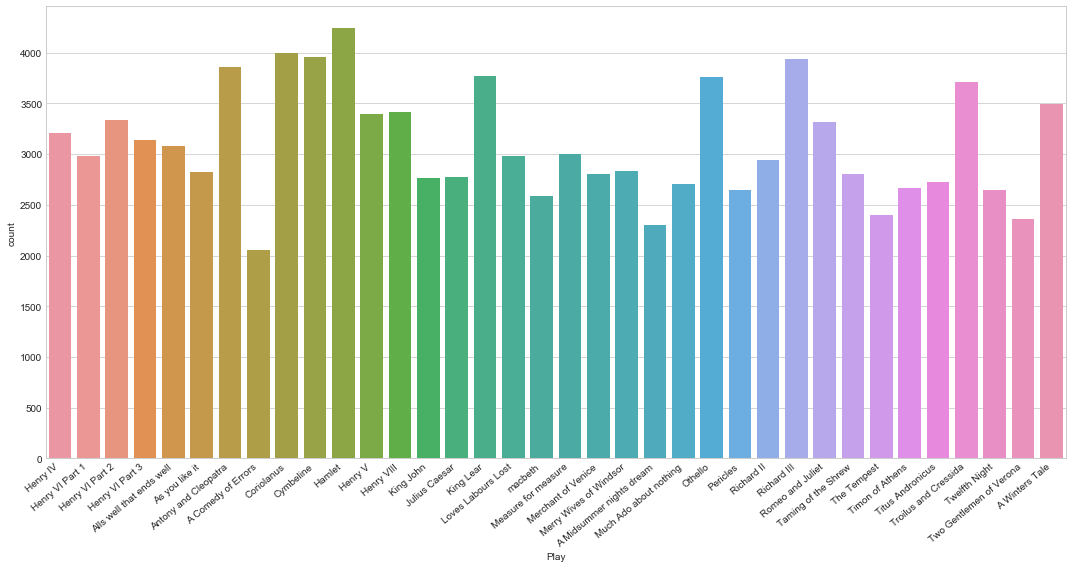

In [10]:
f, ax = plt.subplots(figsize=(15, 8))
ax = sns.countplot(x='Play', data=shakespeare)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In [12]:
# Data pre-processing
df = shakespeare
df['Player'] = df['Player'].fillna('Other')
df_clean = df[['Play', 'PlayerLinenumber', 'ActSceneLine', 'Player', 'PlayerLine', 'Year', "Genre"]].copy()
df_clean = df_clean[df_clean['Player'] != 'Other']
df_clean.reset_index(drop=True, inplace=True)
df_clean.head()

,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine,Year,Genre
0,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,",1597,History
1,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,",1597,History
2,Henry IV,1.0,1.1.3,KING HENRY IV,And breathe short-winded accents of new broils,1597,History
3,Henry IV,1.0,1.1.4,KING HENRY IV,To be commenced in strands afar remote.,1597,History
4,Henry IV,1.0,1.1.5,KING HENRY IV,No more the thirsty entrance of this soil,1597,History


# LDA - Clustering using Topic Models across Genre

In [191]:
# Plotting Year and Genre distribution
df_samp = df_clean[['Play', 'Year', 'Genre']].copy()
df_samp = df_samp.drop_duplicates()
print("Dimension:", df_samp.shape)

Dimension: (36, 3)


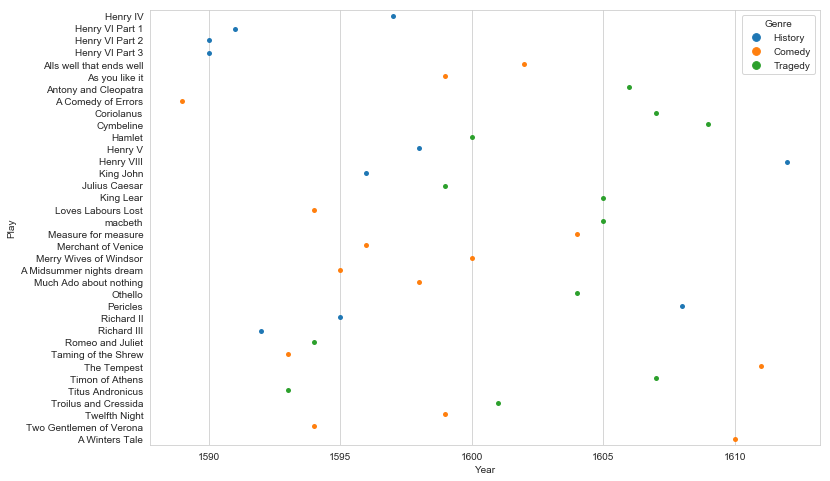

In [192]:
f, ax = plt.subplots(figsize=(12,8))
sns.stripplot(x='Year', y='Play', hue='Genre', data=df_samp);

In [193]:
# Generate Meta
def get_meta(df):
    doc_tokens = TextCleaner().transform(df['PlayerLine'])
    print("Token Length:", len(doc_tokens))
    
    # Corpus preperation
    dictionary = corpora.Dictionary(doc_tokens)
    print(dictionary)

    corpus = [dictionary.doc2bow(doc) for doc in doc_tokens]
    
    return dictionary, corpus

# Perform LDA
def get_lda(dictionary, corpus, num_topics=100):    
    start = time()
    lda = LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, workers=3, passes=50)
    print("LDA compleded in %0.3fs" % (time() - start))
    
    return lda

# Generate Topic Distribution
def get_topic_dist(lda, corpus):
    doc_topic_dist = np.array([[tup[1] for tup in lst] for lst in lda[corpus]])
    
    return doc_topic_dist

In [212]:
# Splitting into 3 subsets across genre
df_g1 = df_clean[(df_clean['Genre'] == 'History')]
df_g1 = df_g1.groupby('Play')['PlayerLine'].apply(' '.join).reset_index()
print('\nSubset G1:', df_g1.shape)
print(df_g1.head())

df_g2 = df_clean[(df_clean['Genre'] == 'Comedy')]
df_g2 = df_g2.groupby('Play')['PlayerLine'].apply(' '.join).reset_index()
print('\nSubset G2:', df_g2.shape)
print(df_g2.head())

df_g3 = df_clean[(df_clean['Genre'] == 'Tragedy')]
df_g3 = df_g3.groupby('Play')['PlayerLine'].apply(' '.join).reset_index()
print('\nSubset G3:', df_g3.shape)
print(df_g3.head())


Subset G1: (10, 2)
              Play                                         PlayerLine
0         Henry IV  So shaken as we are, so wan with care, Find we...
1          Henry V  ACT I PROLOGUE Enter Chorus O for a Muse of fi...
2  Henry VI Part 1  ACT I SCENE I. Westminster Abbey. Dead March. ...
3  Henry VI Part 2  ACT I SCENE I. London. The palace. Flourish of...
4  Henry VI Part 3  ACT I SCENE I. London. The Parliament-house. A...

Subset G2: (14, 2)
                       Play                                         PlayerLine
0        A Comedy of Errors  ACT I SCENE I. A hall in DUKE SOLINUS'S palace...
1  A Midsummer nights dream  ACT I SCENE I. Athens. The palace of THESEUS. ...
2            A Winters Tale  ACT I SCENE I. Antechamber in LEONTES' palace....
3  Alls well that ends well  ACT I SCENE I. Rousillon. The COUNT's palace. ...
4            As you like it  ACT I SCENE I. Orchard of Oliver's house. Ente...

Subset G3: (12, 2)
                   Play                       

In [195]:
# Topic modeling on Genre: History + Tragedy
df_g13 = pd.concat([df_g1, df_g3])
print("Dimension:", df_g13.shape)

dictionary_g13, corpus_g13 = get_meta(df_g13)

lda_g13 = get_lda(dictionary_g13, corpus_g13)

Dimension: (22, 2)
REMOVING PUNCTUATION AND DIGITS... 0 seconds
PARSING TEXT WITH SPACY... 37 seconds
REMOVING STOP WORDS FROM DOCUMENTS... 1 seconds
LEMMATIZING WORDS... 0 seconds
Token Length: 22
Dictionary(17123 unique tokens: ['', 'able', 'abominable', 'abroad', 'absence']...)
LDA compleded in 107.661s


In [196]:
# Evaluation on individual Genre
dictionary_g1, corpus_g1 = get_meta(df_g1)
dictionary_g2, corpus_g2 = get_meta(df_g2)

REMOVING PUNCTUATION AND DIGITS... 0 seconds
PARSING TEXT WITH SPACY... 13 seconds
REMOVING STOP WORDS FROM DOCUMENTS... 0 seconds
LEMMATIZING WORDS... 0 seconds
Token Length: 10
Dictionary(10928 unique tokens: ['', 'able', 'abominable', 'abroad', 'absence']...)
REMOVING PUNCTUATION AND DIGITS... 0 seconds
PARSING TEXT WITH SPACY... 20 seconds
REMOVING STOP WORDS FROM DOCUMENTS... 0 seconds
LEMMATIZING WORDS... 0 seconds
Token Length: 14
Dictionary(11971 unique tokens: ['', 'abbess', 'abbey', 'abbeygate', 'abbeywall']...)


In [201]:
def jensen_shannon(query, matrix):
    """
    This function implements a Jensen-Shannon similarity
    between the input query (an LDA topic distribution for a document)
    and the entire corpus of topic distributions.
    It returns an array of length M where M is the number of documents in the corpus
    """
    # lets keep with the p,q notation above
    p = query[None,:].T # take transpose
    q = matrix.T # transpose matrix
    m = 0.5*(p + q)
    return np.sqrt(0.5*(entropy(p,m) + entropy(q,m)))

def get_most_similar_documents(query,matrix,k=10):
    """
    This function implements the Jensen-Shannon distance above
    and retruns the top k indices of the smallest jensen shannon distances
    """
    sims = jensen_shannon(query,matrix) # list of jensen shannon distances
    return sims.argsort()[:k] # the top k positional index of the smallest Jensen Shannon distances

In [232]:
topics_g1 = lda_g13[corpus_g1]
for topic in topics_g1:
    print(topic)

[(12, 0.038594298), (39, 0.9514625)]
[(12, 0.029595591), (23, 0.09643885), (39, 0.8265037), (63, 0.04274439)]
[(12, 0.01248455), (39, 0.3681734), (63, 0.61194026)]
[(12, 0.14027283), (31, 0.06663279), (39, 0.5925488), (55, 0.0350705), (63, 0.16539867)]
[(12, 0.49539447), (31, 0.078951776), (39, 0.39315343), (63, 0.031585664)]
[(12, 0.027403137), (39, 0.9435166), (63, 0.028991506)]
[(12, 0.023138141), (39, 0.8275597), (63, 0.14848743)]
[(31, 0.047438245), (39, 0.9524455)]
[(12, 0.16071868), (39, 0.8386256)]
[(12, 0.20706175), (31, 0.4705752), (39, 0.31719172)]


In [231]:
topics_g2 = lda_g13[corpus_g2]
for topic in topics_g2:
    print(topic)

[(31, 0.014087589), (39, 0.975197)]
[(31, 0.019946849), (39, 0.95683503), (63, 0.011464457)]
[(23, 0.023265023), (31, 0.017101724), (39, 0.925043), (63, 0.02705532)]
[(23, 0.014034049), (31, 0.02330771), (39, 0.86194277), (63, 0.098584004)]
[(31, 0.0568532), (39, 0.83919305), (63, 0.08443109)]
[(12, 0.03269661), (31, 0.07481916), (39, 0.8430105), (55, 0.0146432305), (63, 0.027335322)]
[(12, 0.028229704), (31, 0.04117369), (39, 0.88891816), (63, 0.032756653)]
[(12, 0.01214263), (31, 0.024140242), (39, 0.92158043), (63, 0.030653412)]
[(31, 0.0426069), (39, 0.89885896), (63, 0.03903643)]
[(23, 0.011139563), (31, 0.041006025), (39, 0.89492625), (63, 0.04299931)]
[(12, 0.010948052), (31, 0.13891901), (39, 0.80606765), (55, 0.012058752), (63, 0.025798993)]
[(12, 0.011334601), (31, 0.11716195), (39, 0.793482), (55, 0.039217766), (63, 0.030994812)]
[(23, 0.010955789), (31, 0.023749553), (39, 0.8765291), (55, 0.051332787), (63, 0.027613694)]
[(31, 0.033380024), (39, 0.92437893), (63, 0.02422998

## Need to plot these topics and show intersection between genre so that our hypothesis (Shakespeare wrote them all) is satisfied

### http://jeriwieringa.com/2017/06/21/Calculating-and-Visualizing-Topic-Significance-over-Time-Part-1/
    

# Classify Whether or Not `is_shakespeare`

The names of Shakespeare's contemporaries were derived from the [Royal Shakespeare Company](https://www.rsc.org.uk/shakespeares-contemporaries/meet-the-contemporaries) and the text of the plays
was acquired from [archive.org](https://archive.org).

_Hypothesis:_  Shakespeare's style is sufficiently unique from playwrights of his time that a classifier can be built that is capable of predicting whether or not a given line was written by Shakespeare or not.  

In [8]:
# use requests and bs4

thomas_kyd = 'https://archive.org/stream/worksthomaskyd00kydgoog/worksthomaskyd00kydgoog_djvu.txt'
christopher_marlowe = 'https://archive.org/stream/worksofchristoph00marlrich/worksofchristoph00marlrich_djvu.txt'
ben_johnson = 'https://archive.org/stream/completeplaysofb01jonsuoft/completeplaysofb01jonsuoft_djvu.txt'
thomas_dekker = 'https://archive.org/stream/dramaticworksth02shepgoog/dramaticworksth02shepgoog_djvu.txt'
john_webster = 'NOT FOUND'
beaumont_fletcher = 'https://archive.org/stream/worksoffrancisbe004beau/worksoffrancisbe004beau_djvu.txt'
philip_massinger = 'https://archive.org/stream/plays00massgoog/plays00massgoog_djvu.txt'
john_ford = 'NOT FOUND'

urls = {'thomas_kyd': thomas_kyd, 'christopher_marlowe': christopher_marlowe,
       'ben_johnson': ben_johnson, 'thomas_dekker': thomas_dekker,
       'beaumont_fletcher': beaumont_fletcher, 'philip_massinger': philip_massinger}

# not_shakespeare = list()
for author, url in urls.items():
    print('Acquiring plays for {}'.format(author))
#     remove bad text by hand (e.g. credits)
#     don't want to run twice
#     get_url = requests.get(url)
#     txt = get_url.text
#     soup = BeautifulSoup(txt, "html.parser")
#     txt_clean = str(soup.find_all('pre')[0])
#     not_shakespeare.append(txt_clean)
#     with open(r'data/{}.txt'.format(author), 'w') as f:
#         f.write(txt_clean)

Acquiring plays for thomas_kyd
Acquiring plays for christopher_marlowe
Acquiring plays for ben_johnson
Acquiring plays for thomas_dekker
Acquiring plays for beaumont_fletcher
Acquiring plays for philip_massinger


Read in plays from six of Shakespeare's contemporaries.  Note that junk text was manually identified & removed from each file that mostly pertained to the credits and funding of the archive work (which were saved off in a separate file in this repository).  Introductions by other authors were also removed by hand. 

In [9]:
collections = list()
for author, _ in urls.items():
    print('Reading in plays for {}'.format(author))
    with open(r'data/{}.txt'.format(author), 'r') as f:
        collections.append(f.readlines())

Reading in plays for thomas_kyd
Reading in plays for christopher_marlowe
Reading in plays for ben_johnson
Reading in plays for thomas_dekker
Reading in plays for beaumont_fletcher
Reading in plays for philip_massinger


Flatten the nested list using a `lambda` function, then splitting on newline characters such that lines are the unit of analysis.

In [10]:
# set up data
# remove the admin text in files BY HAND
print('Did you remove the credits from the text files, so that only plays are in the data?')
flatten = lambda l: [item for sublist in l for item in sublist]
not_shakespeare = flatten(collections)
not_shakespeare = [str(s).split('\n') for s in not_shakespeare] 
not_shakespeare = flatten(collections)
np.array(not_shakespeare)[:5]

Did you remove the credits from the text files, so that only plays are in the data?


array(['\n', '\n', 'The Spanish Tragedie^ IV. It. \n', '\n',
       "The Latin elegiacs mingled with the English verses, might ' \n"],
      dtype='<U100')

Note that there is still noise.  Newline characters and breaks between acts in the play need to be identified and removed.  

Next Shakespeare's lines are read in from the Kaggle dataset.

In [11]:
lines = list()
with open('data/alllines.txt') as f:
    lines.append(f.readlines())
    
lines = flatten(lines)
lines[:5]

['"ACT I"\n',
 '"SCENE I. London. The palace."\n',
 '"Enter KING HENRY, LORD JOHN OF LANCASTER, the EARL of WESTMORELAND, SIR WALTER BLUNT, and others"\n',
 '"So shaken as we are, so wan with care,"\n',
 '"Find we a time for frighted peace to pant,"\n']

Convert data to `X` and `y` by generating a vector of zeros for all lines that are from Shakespeare's contemporaries in alignment with the existing data.  The same is done with a vector of ones to represent the `y` for Shakespeare's lines.  These are then put into a `DataFrame` and shuffled using the `pd.DataFrame.sample` method.

In [12]:
X, y = np.array(not_shakespeare), np.zeros(len(not_shakespeare))
X, y = np.hstack([X, lines]), np.hstack([y, np.ones([len(lines)])])

_df = pd.DataFrame({'X': X, 'y': y})
_df.y = _df.y.astype(np.int8)
_df = _df.sample(random_state=7, frac=1)
_df.head(25)

,X,y
310973,"""Being spoke behind your back, than to your fa...",1
119000,Volp. And thou use them scurvily ! \n,0
241107,"""her without her tongue. O, that woman that ca...",1
226243,"""life: which if I can save, so, if not, honour...",1
60178,\n,0
193113,"Of noble war extinguish Lovi^s dim tapar,] So ...",0
108087,\n,0
105787,\n,0
232199,"""spoil of the city until night: for with these...",1
250517,"""Pray, get you out.""\n",1


Below filters are applied to remove newlines, `NaN`s, Act demarcations, paragraphs, and lines with fewer than eight words.  This appears to get a reasonable sample dataset with 103355 rows of lines in the datatset.  

Filter out:

- New lines
- `NaN`s
- Lines designating "ACT _"
- New lines with paragraphs
- Lines shorter than 8 words

In [13]:
# filter out (subjectively determined) noisy lines
_df = _df.loc[_df.X != '\n']
_df = _df.loc[~_df.X.str.contains('nan')]
_df = _df.loc[~_df.X.str.contains('ACT')]
_df = _df.loc[_df.X != 'p\n']
_df = _df.loc[_df.X.str.split().str.len() > 8]

print(_df.shape)

_df.head(25)

(103355, 2)


,X,y
310973,"""Being spoke behind your back, than to your fa...",1
241107,"""her without her tongue. O, that woman that ca...",1
226243,"""life: which if I can save, so, if not, honour...",1
193113,"Of noble war extinguish Lovi^s dim tapar,] So ...",0
232199,"""spoil of the city until night: for with these...",1
62430,"But stay a while, let me be king till night, 2...",0
22079,sort as we behold the prouidence of our almigh...,0
275707,"""And fortune led you well: you have the captiv...",1
11642,"Hier, Nay, then I care not; come, and we shall...",0
157981,To trust thy sacred life to an Egyptian ? \n,0


Check the distribution of the number of words in each line after the filter was applied.  Note that we have many  observations of reasonable length.

In [14]:
_df.X.str.split().str.len().describe()

count    103355.000000
mean         10.344492
std           1.874410
min           9.000000
25%           9.000000
50%          10.000000
75%          11.000000
max         163.000000
Name: X, dtype: float64

Check the breakdown between Shakespeare's lines and his contemporaries.  We see that Shakespeare's lines represent about 33% of the data.

In [15]:
# baseline
pd.Series(y).value_counts() / y.shape[0]

0.0    0.667154
1.0    0.332846
dtype: float64

## Test Classifiers

First we split the data 70-30, stratifying on the `y` vector and setting `random_state` for reproducibility.  

In [16]:
# stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7, random_state=777, stratify=y)

### Test 1:  `TfidfVectorizer` feeding `LinearSVC` via `GridSearchCV`

Below an `sklearn.pipeline` is set up to enable a grid-search of hyperparameters for the `TfidfVectorizer` and the `LinearSVC` objects.  A linear support vector classifier was chosen as a baseline model for its reputation on text data. The model is deliberately kept simple for use as a baseline first attempt.  

In [40]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC())
])

params = {'tfidf__ngram_range': [(1,2), (1,3), (1,4)],
         'clf__C': [.01, .1, 1, 10, 100, 1000]}

grid = GridSearchCV(pipeline, params, cv=3, verbose=1, n_jobs=4)
grid.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  7.8min
[Parallel(n_jobs=4)]: Done  54 out of  54 | elapsed: 12.5min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'tfidf__ngram_range': [(1, 2), (1, 3), (1, 4)], 'clf__C': [0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

Isolate the hyperparameters that characterize the `best_estimator_` from the `grid` object. 

In [41]:
grid.best_estimator_

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
 ...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

The best model's `accuracy_score = 0.849` and is a solid baseline model.

In [42]:
yhat_test = grid.predict(X_test.astype(str))
test_acc = accuracy_score(y_test, yhat_test)
yhat_train = grid.predict(X_train.astype(str))
train_acc = accuracy_score(y_train, yhat_train) 

print(f'''
Training Accuracy: {train_acc}
Testing Accuracy: {test_acc}
''')

_, __ = binary_confusion_matrix(y_test, yhat_test)
_


Training Accuracy: 0.9904598481259044
Testing Accuracy: 0.8493984303414207


        Condition Positive:                        61282
        Condition Negative:                        39122
        Total Observations:                        100404
        
        True Positive:                             56573
        True Negative:                             28710
        False Positive:                            10412
        False Negative                             4709
        
        True Positive Rate (recall):               92.32%
        True Negative Rate (specificity):          73.39%
        False Positive Rate (fall-out):            26.61%
        False Negative Rate (miss rate):           7.68%
        
        Positive Predictive Value (precision):     84.46%
        Negative Predictive Value:                 85.91%
        


,(+) actual,(-) actual
(+) predicted,56573,10412
(-) predicted,4709,28710


In [43]:
dump(grid, 'models/linearsvc.joblib')

['linearsvc.joblib']

### Test 2:  `TfidfVectorizer` feeding `MultinomialNB` via `GridSearchCV`

Now we test a similar pipeline setup to before, only this time with a `MultinomialNB`.  As with the previous approach, a grid-search is performed over a range of hyperparameters for both steps in the process.  

Note:  Several classifiers were sampled, yet several crashed.  For example, `XGBClassifier`'s grid-search was terminated by hand due to compute time.  `RandomForestClassifier` was also terminated for the same reason.  

Also, via experimentation it was determined that an `ngram_range=(1,2)` works best on this data, so this parameter was not varied for computational turnover consideration.

In [36]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

params = {'tfidf__ngram_range': [(1,2)],
         'clf__alpha': [0, .001, .01, .1, 1],
         'clf__fit_prior': [True, False] 
         }

grid = GridSearchCV(pipeline, params, cv=3, verbose=1, n_jobs=4)
grid.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:  1.8min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...rue,
        vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'tfidf__ngram_range': [(1, 2)], 'clf__alpha': [0, 0.001, 0.01, 0.1, 1], 'clf__fit_prior': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [37]:
yhat_test = grid.predict(X_test.astype(str))
test_acc = accuracy_score(y_test, yhat_test)
yhat_train = grid.predict(X_train.astype(str))
train_acc = accuracy_score(y_train, yhat_train) 

print(f'''
Training Accuracy: {train_acc}
Testing Accuracy: {test_acc}
''')

_, __ = binary_confusion_matrix(y_test, yhat_test)
_


Training Accuracy: 0.9813294745873404
Testing Accuracy: 0.8573264013385921


        Condition Positive:                        67872
        Condition Negative:                        32532
        Total Observations:                        100404
        
        True Positive:                             60266
        True Negative:                             25813
        False Positive:                            6719
        False Negative                             7606
        
        True Positive Rate (recall):               88.79%
        True Negative Rate (specificity):          79.35%
        False Positive Rate (fall-out):            20.65%
        False Negative Rate (miss rate):           11.21%
        
        Positive Predictive Value (precision):     89.97%
        Negative Predictive Value:                 77.24%
        


,(+) actual,(-) actual
(+) predicted,60266,6719
(-) predicted,7606,25813


In [38]:
grid.best_estimator_

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
 ...rue,
        vocabulary=None)), ('clf', MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True))])

In [39]:
dump(grid, 'models/multinomialnb.joblib')

['models/multinomialnb.joblib']

### Test 3:  `TfidfVectorizer` feeding `BernoulliNB` via `GridSearchCV`

A similar model is tested for incremental improvement below.  

In [32]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', BernoulliNB())
])

params = {'tfidf__ngram_range': [(1,2)],
         'clf__alpha': [0, .001, .0001, .01, .1],
         'clf__fit_prior': [True]
         }

grid = GridSearchCV(pipeline, params, cv=3, verbose=1, n_jobs=4)
grid.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=4)]: Done  18 out of  18 | elapsed:  1.2min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ... vocabulary=None)), ('clf', BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'tfidf__ngram_range': [(1, 2)], 'clf__alpha': [0, 0.01, 0.1, 1, 10, 100], 'clf__fit_prior': [True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

Note performance is not as good as `MultinomialNB`.  

In [35]:
yhat_test = grid.predict(X_test.astype(str))
test_acc = accuracy_score(y_test, yhat_test)
yhat_train = grid.predict(X_train.astype(str))
train_acc = accuracy_score(y_train, yhat_train) 

print(f'''
Training Accuracy: {train_acc}
Testing Accuracy: {test_acc}
''')

_, __ = binary_confusion_matrix(y_test, yhat_test)
_


Training Accuracy: 0.9681397344124163
Testing Accuracy: 0.8427054699015976


        Condition Positive:                        66384
        Condition Negative:                        34020
        Total Observations:                        100404
        
        True Positive:                             58788
        True Negative:                             25823
        False Positive:                            8197
        False Negative                             7596
        
        True Positive Rate (recall):               88.56%
        True Negative Rate (specificity):          75.91%
        False Positive Rate (fall-out):            24.09%
        False Negative Rate (miss rate):           11.44%
        
        Positive Predictive Value (precision):     87.76%
        Negative Predictive Value:                 77.27%
        


,(+) actual,(-) actual
(+) predicted,58788,8197
(-) predicted,7596,25823


In [33]:
grid.best_estimator_

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
 ...vocabulary=None)), ('clf', BernoulliNB(alpha=0.01, binarize=0.0, class_prior=None, fit_prior=True))])

In [34]:
dump(grid, 'models/bernoullinb.joblib')

['models/bernoullinb.joblib']

### Test 4:  Try and Improve Best Model with `CountVectorizer` as Feeding Mechanism

In [49]:
pipeline = Pipeline([
    ('count', CountVectorizer()),
    ('clf', MultinomialNB())
])

params = {'count__ngram_range': [(1,2), (1,3)],
         'count__min_df': [1, 2, 4],
         'clf__alpha': [.1],
         'clf__fit_prior': [True] 
         }

grid = GridSearchCV(pipeline, params, cv=3, verbose=1, n_jobs=4)
grid.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=4)]: Done  18 out of  18 | elapsed:  1.3min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('count', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'count__ngram_range': [(1, 2), (1, 3)], 'count__min_df': [1, 2, 4], 'clf__alpha': [0.1], 'clf__fit_prior': [True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [50]:
yhat_test = grid.predict(X_test.astype(str))
test_acc = accuracy_score(y_test, yhat_test)
yhat_train = grid.predict(X_train.astype(str))
train_acc = accuracy_score(y_train, yhat_train) 

print(f'''
Training Accuracy: {train_acc}
Testing Accuracy: {test_acc}
''')

_, __ = binary_confusion_matrix(y_test, yhat_test)
print(grid.best_estimator_)
_


Training Accuracy: 0.9726515646275926
Testing Accuracy: 0.8598163419784073


        Condition Positive:                        62954
        Condition Negative:                        37450
        Total Observations:                        100404
        
        True Positive:                             57932
        True Negative:                             28397
        False Positive:                            9053
        False Negative                             5022
        
        True Positive Rate (recall):               92.02%
        True Negative Rate (specificity):          75.83%
        False Positive Rate (fall-out):            24.17%
        False Negative Rate (miss rate):           7.98%
        
        Positive Predictive Value (precision):     86.49%
        Negative Predictive Value:                 84.97%
        
Pipeline(memory=None,
     steps=[('count', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy

,(+) actual,(-) actual
(+) predicted,57932,9053
(-) predicted,5022,28397


In [51]:
dump(grid, 'models/multinomialnb_countvec.joblib')

['models/multinomialnb_countvec.joblib']

## Conclusions on Classification of `is_shakespeare`

It is clear that using some sensible pre-processing steps alongside some versatile algorithms that we are able to classify reasonably well whether a given line from a play (from Shakespeare's time) was indeed written by Shakespeare.  These models are likely only scratching the surface, and it is likely that custom word embeddings could improve on these models.  It is also possible that semantic analysis could help in modeling efforts.  

The highest accuracy score was achieved using the `CountVectorizer` feeding a `MultinomialNB` model, achieving 85.98% accuracy on the test set.  This model also achieved a true positive rate of 92% and a precision of 86.49%.  All-in-all these are pretty good numbers given the simplicity of the approaches.  